In [1]:
!pip install kiwipiepy

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
from kiwipiepy import Kiwi
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

In [60]:
df=pd.read_csv('./umsun_C_3_sborder_v4.csv', encoding='utf-8')   # obs: 9,265
print(df.head(3))

docs = df['talk_ko'].tolist()
docs_new = df['talk_ko_new'].tolist()
print(docs[:10])

   text_id grade                            talk_ko  \
0    10804     C       무첨가라 넘 좋긴 한데두유초심자가 먹기에는 힘들어요   
1    10805     C           식품첨가물이 없어서 즐겨 먹는 약콩두유입니다   
2    10806     C  노브랜드 제품이 생각보다 괜찮은것 같아요성분도 마음에 드네요   

                            talk_ko_new  
0     무첨가라 너무 좋긴 한데 두 이 초심자가 먹기에는 힘들어요.  
1            식품첨가물이 없어서 즐겨 먹는 약콩 두유입니다.  
2  노브랜드 제품이 생각보다 괜찮은 것 같아 여성분도 마음에 드네요.  
['무첨가라 넘 좋긴 한데두유초심자가 먹기에는 힘들어요', '식품첨가물이 없어서 즐겨 먹는 약콩두유입니다', '노브랜드 제품이 생각보다 괜찮은것 같아요성분도 마음에 드네요', '노브랜드는 가격만큼 하는 거같아요  무난해용 ', '체했을 때 편의점에서 응급으로 사먹는 제품  첨가물 아쉽지만', '건강한음료가 맞나요 신뢰성이 떨어지네요', '귀리음료 맛 별로 시켰는데 애들은 오렌지망고를 제일 좋아하네요', '오렌지 망고가 들어가있는 두유 맛있나요', '아이가 잘먹어요 단호박과 감귤의 조합은 좀 신선하네요', '달달하니 아기가 좋아하겠네요 양도많은것같고 간식돼지울아기한테 딱일것같네요']


In [49]:
# 불용어를 정의한다
user_stop_word = ["좋", "먹", "거", "개", "바", "뻥", "중", "눌", ]

# 토크나이저에 ***만 추가한다      https://incredible.ai/nlp/2016/12/28/NLP/
extract_pos_list = ["NNG", "NNP", "NNB", "NR", "NP", "VV", "VA","MAG","IC"]

class CustomTokenizer:
    def __init__(self, tagger):
        self.tagger = tagger
    def __call__(self, text):
        result = list()
        for word in self.tagger.tokenize(text):
            # 명사이고, 길이가 2이상인 단어이고, 불용어 리스트에 없으면 추가하기
            if word[1] in extract_pos_list and word[0] not in user_stop_word: #len(word[0]) > 1 and
                result.append(word[0])
        return result

In [86]:
kiwi = Kiwi()
kiwi.add_user_word("노브랜드","NNP")
kiwi.add_user_word("한살림","NNP")
kiwi.add_user_word("이마트","NNP")
kiwi.add_user_word("피코크","NNP")
kiwi.add_user_word("누네띠네","NNP")
kiwi.add_user_word("동원참치","NNP")
kiwi.add_user_word("떡뻥","NNP")
kiwi.add_user_word("베지밀","NNP")
kiwi.add_user_word("네스카페","NNP")
kiwi.add_user_word("맥스봉","NNP")
kiwi.add_user_word("오뚜기","NNP")
kiwi.add_user_word("오징어집","NNP")
kiwi.add_user_word("오곡쿠키","NNP")

kiwi.add_user_word("10대","NR")
kiwi.add_user_word("20대","NR")
kiwi.add_user_word("30대","NR")
kiwi.add_user_word("40대","NR")
kiwi.add_user_word("50대","NR")
kiwi.add_user_word("베스킨라빈스","NNP")
kiwi.add_user_word("이산화규소","NNP")
kiwi.add_user_word("중위험","NNP")
kiwi.add_user_word("고위험","NNP")
kiwi.add_user_word("저위험","NNP")
kiwi.add_user_word("우리밀","NNP")
kiwi.add_user_word("열일","NNG")
kiwi.add_user_word("유전자변형","NNG")
kiwi.add_user_word("유화증진제","NNG")
kiwi.add_user_word("유화제","NNG")
kiwi.add_user_word("스프레드","NNG")
kiwi.add_user_word("식품첨가물","NNG")


custom_tokenizer = CustomTokenizer(kiwi)
vectorizer = CountVectorizer(tokenizer=custom_tokenizer)

In [17]:
# Pre-calculate embeddings
from sentence_transformers import SentenceTransformer
#embedding_model = SentenceTransformer("sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens")

embedding_model = SentenceTransformer("snunlp/KR-SBERT-V40K-klueNLI-augSTS")
embeddings = embedding_model.encode(docs, show_progress_bar=True)

Batches:   0%|          | 0/290 [00:00<?, ?it/s]

In [7]:
# from hdbscan import HDBSCAN
# hdbscan_model = HDBSCAN(min_cluster_size=100, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

In [90]:
topic_model = BERTopic( #embedding_model="sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens", \
        # embedding_model="paraphrase-multilingual-MiniLM-L12-v2",
        embedding_model=embedding_model,
        # hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer,
        nr_topics="auto", # 문서를 대표하는 토픽의 갯수
        top_n_words=3,
        calculate_probabilities=True)
	
topics, probs = topic_model.fit_transform(docs)
#topic_model.save("model_S_2024_C_7")

In [91]:
topic_model.get_topic_info()


,Topic,Count,Name,Representation,Representative_Docs
0,-1,4100,-1_사_아이_있,"[사, 아이, 있]","[우리아이 이거 정말좋아하는데 성분이 정말 아쉽네요 좀 더 좋았으면 좋았을거같은데,..."
1,0,1987,0_우유_요거_맛있,"[우유, 요거, 맛있]",[저희 아기가 멸균우유 먹고 있는데 이제 생우유로 바꾸려고 하는데 안그래도 검색해보...
2,1,354,1_초코_초콜릿_아몬드,"[초코, 초콜릿, 아몬드]","[초코맛이 진해서 아이가좋아하더라그요 근데 첨가물이 좀, 첨가물은 아쉽지만 초코맛이..."
3,2,191,2_커피_맥주_안주,"[커피, 맥주, 안주]","[커피향으로 먹는맛, 커피랑 먹으면 맛있어요, 커피와 먹기에 좋아요]"
4,3,170,3_향료_들어가_향미,"[향료, 들어가, 향미]","[향료가 들어가 있긴 하지만 상큼하니 맛있어요, 향료가 들어가긴했지만 맛있네요, 향..."
...,...,...,...,...,...
81,80,11,80_동원_동원참치_골뱅이,"[동원, 동원참치, 골뱅이]","[역시 국민참치는 동원인가봐요 믿고 앞으로도 구매해야겠어용, 동원에서도 골뱅이가 여..."
82,81,11,81_토마토_의사_면역력,"[토마토, 의사, 면역력]",[효능이 다양한 토마토에 들어있는 리코펜은 항산화 작용이 뛰어나 면역력을 높여주는 ...
83,82,11,82_하겐다즈_비싸_사치,"[하겐다즈, 비싸, 사치]","[하겐다즈 너무맛있는데 비싸죠, 하겐다즈는 첨가물이없군요 그래서 비싼가, 하겐다즈 ..."
84,83,11,83_손가락_끼우_끼,"[손가락, 끼우, 끼]","[손가락에 끼워먹는거 우리딸들이 엄청 좋아해요, 아이들과 손가락에 끼워먹으니 맛있네..."


In [92]:
hierarchical_topics = topic_model.hierarchical_topics(docs_new)
tree = topic_model.get_topic_tree(hierarchical_topics)
print(tree)

100%|███████████████████████████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 485.01it/s]

.
├─중위험_저위험_위험
│    ├─■──위험_첨가물_저위험 ── Topic: 67
│    └─중위험_저위험_있
│         ├─■──중위험_저위험_헐 ── Topic: 9
│         └─■──저위험_중위험_위험군 ── Topic: 15
└─요구르트_초코_맛있
     ├─초코_우유_맛있
     │    ├─딸기_건조_향
     │    │    ├─■──딸기_과일_블루베리 ── Topic: 20
     │    │    └─■──딸기_건조_쨈 ── Topic: 35
     │    └─초코_우유_맛있
     │         ├─도시락_편의점_괜찮
     │         │    ├─괜찮_어디_무난하
     │         │    │    ├─어디_처음_번
     │         │    │    │    ├─■──어디_처음_보 ── Topic: 26
     │         │    │    │    └─■──번_작년_저두요 ── Topic: 46
     │         │    │    └─괜찮_무난하_잘
     │         │    │         ├─■──괜찮_무난하_생각 ── Topic: 5
     │         │    │         └─■──잘_집_무난하 ── Topic: 42
     │         │    └─도시락_편의점_노브랜드
     │         │         ├─노브랜드_안_덕분
     │         │         │    ├─■──노브랜드_덕분_가격 ── Topic: 22
     │         │         │    └─■──안_노브랜드_사 ── Topic: 8
     │         │         └─도시락_편의점_장난감
     │         │              ├─장난감_마트_이마트
     │         │              │    ├─■──장난감_초콜렛_크래커 ── Topic: 64
     │     

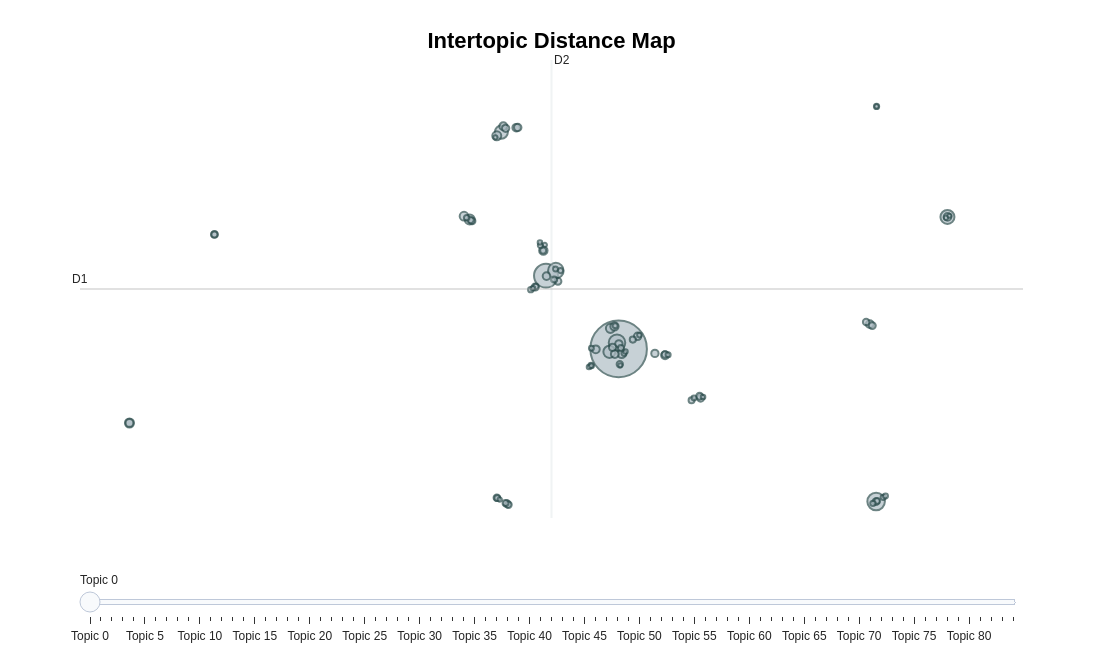

In [93]:
topic_model.visualize_topics()

In [94]:
topic_model.visualize_hierarchy()

In [12]:
# Coherence
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel

# Preprocess documents for coherence evaluation
documents = pd.DataFrame({"Document": docs, "ID": range(len(docs)), "Topic": topics})
documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ''.join})
cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

# Extract vectorizer and analyzer for BERTopic
vectorizer = topic_model.vectorizer_model
analyzer = vectorizer.build_analyzer()

# Extract features for topic coherence evaluation
words = vectorizer.get_feature_names_out()
tokens = [analyzer(doc) for doc in cleaned_docs]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]

# Extract words in each topic if they are non-empty and exist in the dictionary
topic_words = []
#topic_words = [list(zip(*model_2024_B_3.get_topic(topic)))[0] for topic in range(len(set(topics))-1)]
for topic in range(len(set(topics))-topic_model._outliers):
  words = list(zip(*topic_model.get_topic(topic)))[0]
  words = [word for word in words if word in dictionary.token2id]
  topic_words.append(words)
topic_words = [words for words in topic_words if len(words)>0]

# Evaluate Coherence
coherence_model = CoherenceModel(topics=topic_words, texts=tokens, corpus=corpus, dictionary=dictionary, coherence='c_v')
coherence = coherence_model.get_coherence()
print("Coherence Score: ", coherence)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Coherence Score:  0.8537686861097831


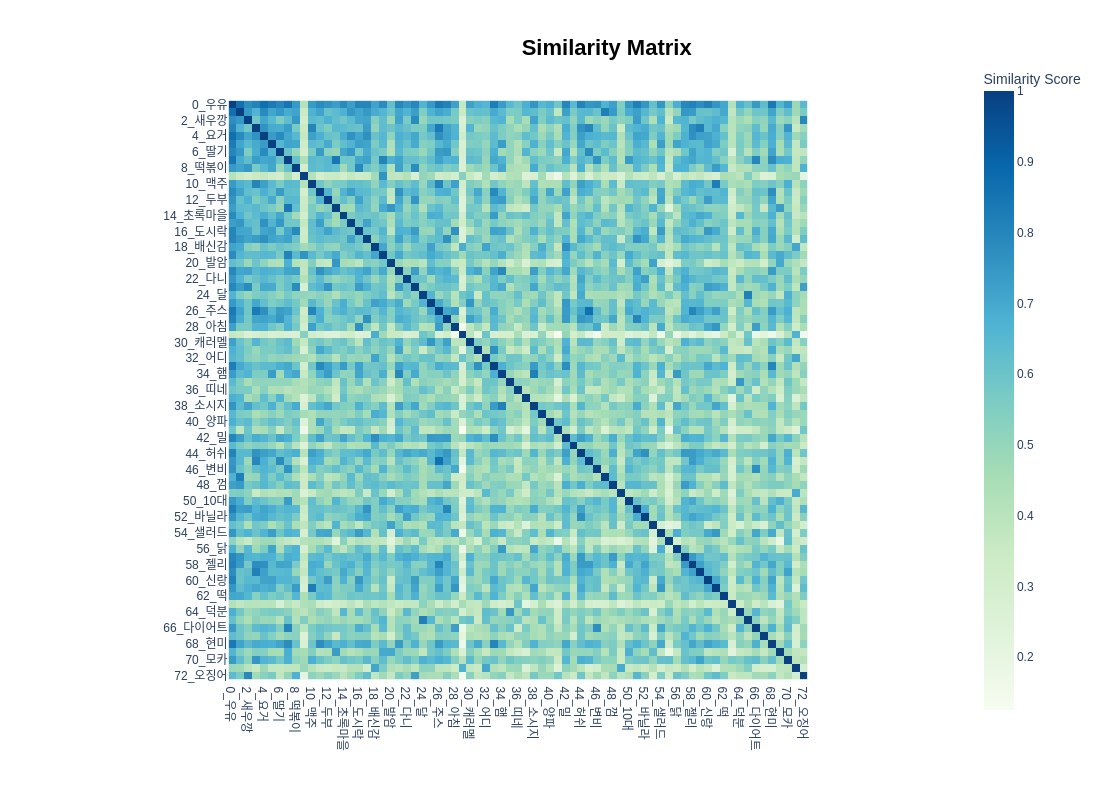

In [42]:
topic_model.visualize_heatmap()